# HPE CSI DRIVER FOR KUBERNETES 
created by Dirk Derichsweiler / k8s@hpe.com
& Stephan Koch / stephan.koch@hpe.com
/ April 2020

A Container Storage Interface (CSI) Driver for Kubernetes. The HPE CSI Driver for Kubernetes allows you to use a Container Storage Provider (CSP) to perform data management operations on storage resources. The architecture of the CSI driver allows block storage vendors to implement a CSP that follows the spec (a browser friendly version).

It allows a complete separation of concerns between upstream Kubernetes core, SIG Storage (CSI owners), CSI driver author (HPE) and the backend CSP developer.


for more Information: https://scod.hpedev.io/csi_driver/

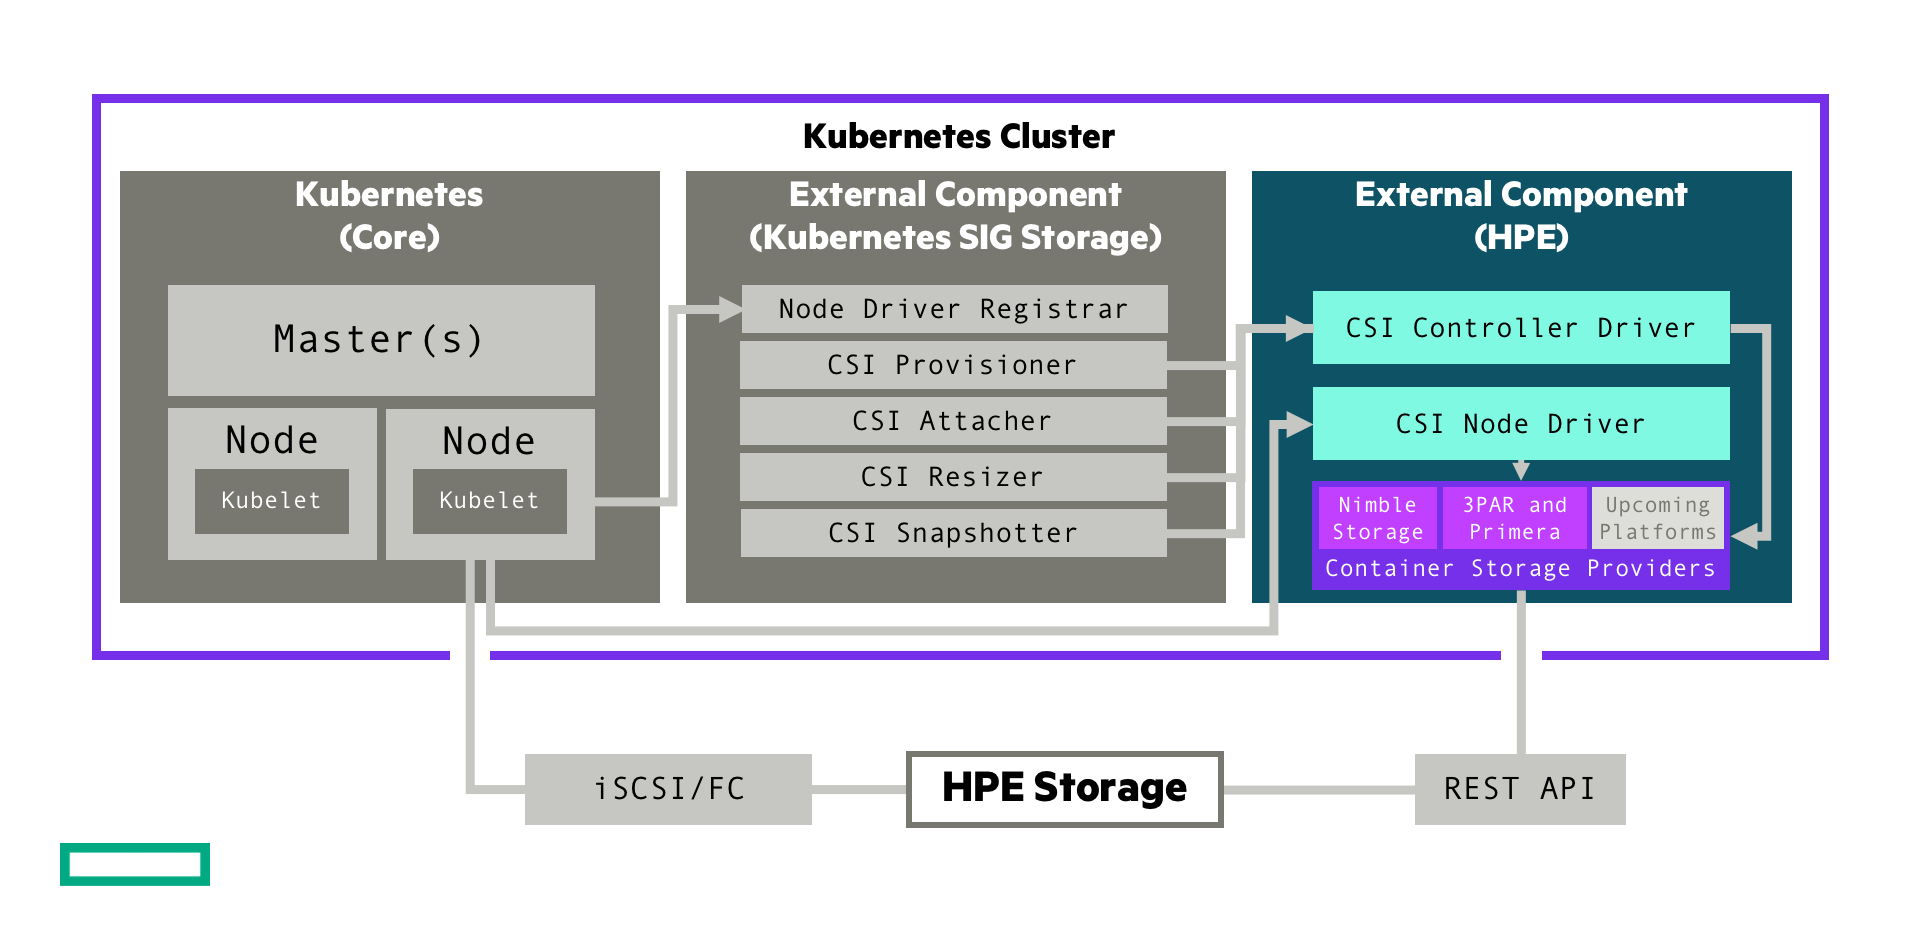

## select the right cluster

In [1]:
ls ~/k8sconfig

azure-ddk8s                      hpecp-DD_PLAYGROUND-admin-config
bigmama-k3s                      hpecp-ddtestcluster-admin-config
ddk1-ddk8s-config                hpecp_hpc_demo
DESKTOP-V6NAVHT-minikube-config  nimbletest_kubeconfig
hcp_barem_sy480                  rancher-demo02-centos
hpecp_csi_demo_admin_kubeconfig  rancher-rke-centos
hpecp-DDK8S-HPECP-admin-config


In [2]:
export KUBECONFIG=~/k8sconfig/hpecp_hpc_demo

In [3]:
kubectl cluster-info
kubectl get nodes
#kubectl get pods -A

Kubernetes master is running at https://ddcp5.container.demo.local:10004
KubeDNS is running at https://ddcp5.container.demo.local:10004/api/v1/namespaces/kube-system/services/kube-dns:dns/proxy
Metrics-server is running at https://ddcp5.container.demo.local:10004/api/v1/namespaces/kube-system/services/https:metrics-server:/proxy

To further debug and diagnose cluster problems, use 'kubectl cluster-info dump'.
NAME                          STATUS   ROLES    AGE     VERSION
ddcp14.container.demo.local   Ready    master   2d16h   v1.17.0
ddcp15.container.demo.local   Ready    worker   2d16h   v1.17.0


## Install with Helm

other installation methods: 
- Object Configuration Files (https://github.com/hpe-storage/csi-driver)
- Helm Charts (https://hub.helm.sh)
- Operator (https://operatorhub.io)

In [4]:
helm version

version.BuildInfo{Version:"v3.0.2", GitCommit:"19e47ee3283ae98139d98460de796c1be1e3975f", GitTreeState:"clean", GoVersion:"go1.13.5"}


In [5]:
helm repo add hpe-storage https://hpe-storage.github.io/co-deployments/

"hpe-storage" has been added to your repositories


In [6]:
helm repo update
helm search repo hpe-csi-driver

Hang tight while we grab the latest from your chart repositories...
...Successfully got an update from the "hpe-storage" chart repository
...Successfully got an update from the "vmware-tanzu" chart repository
...Successfully got an update from the "oteemo" chart repository
...Successfully got an update from the "halkeye" chart repository
...Successfully got an update from the "jetstack" chart repository
...Successfully got an update from the "harbor" chart repository
...Successfully got an update from the "bitnami" chart repository
...Successfully got an update from the "stable" chart repository
Update Complete. ⎈ Happy Helming!⎈ 
NAME                      	CHART VERSION	APP VERSION	DESCRIPTION                                       
hpe-storage/hpe-csi-driver	1.2.0        	1.1.1      	A Helm chart for installing the HPE CSI Driver ...


### Helm Parameters

|Parameter|	Description	|Default|
|:--------|:-----------:|:------|
|backendType	|Name of the HPE Storage backend type (nimble, hpe3parprimera)|	nimble|
|secret.create	|Enabled creation of secret along with driver deployment	|true|
|secret.backend	|HPE storage backend hostname or IP address.	|192.168.1.1|
|secret.username|	Username for the backend.|	admin|
|secret.password|	Password for the backend.	|admin|
|crd.nodeInfo.create|	Create nodeinfo CRDs required by HPE CSI driver. Should only enable with HELM 2, as they are automatically created with HELM 3 without this flag.|	false|
|crd.volumeInfo.create|	Create volumeinfo CRDs required by HPE CSI driver for 3PAR Primera. Should only enable with HELM 2, as they are automatically created with HELM 3 without this flag.|	false|
|logLevel|	Log level. Can be one of info, debug, trace, warn and error|	info|
|imagePullPolicy	|Image pull policy (Always, IfNotPresent, Never).	|Always|
|storageClass.name	|The name to assign the created StorageClass.|	hpe-standard|
|storageClass.create|	Enables creation of StorageClass to consume this hpe-csi-driver instance	|true|
|storageClass.defaultClass|	Whether to set the created StorageClass as the clusters default StorageClass.	|false|
|storageClass.parameters.fsType|	Type of file system being used (ext4, ext3, xfs, btrfs)	|xfs|
|storageClass.parameters.volumeDescription|	Volume description for volumes created using HPE CSI driver|	-|
|storageClass.parameters.accessProtocol|	Access protocol to use for storage connectivity (iscsi, fc)	|iscsi|
|storageClass.parameters.provisioningType|	Provisioning type for HPE 3PAR Primera	|tpvv|
|storageClass.parameters.cpg|	CPG type for HPE 3PAR Primera	|FC_r6|

In [ ]:
helm install hpe-csi hpe-storage/hpe-csi-driver --namespace kube-system --set secret.backend=<nimbleip> --set secret.username=<nimbleuser> --set secret.password=<nimblepassword>
#helm uninstall hpe-csi --namespace kube-system

**For FibreChannel Access:**

Above we installed for the iscsi protocol.
For FC use:

``helm install hpe-csi hpe-storage/hpe-csi-driver --namespace kube-system --set storageClass.parameters.accessProtocol=fc --set secret.backend=<nimbleip> --set secret.username=<user> --set secret.password=<PW>``

and do manually the FC Zoning.

Adjust the accessProtocol for the StorageClass from iscsi to fc

``accessProtocol: fc``

In [7]:
helm list --all-namespaces

NAME   	NAMESPACE  	REVISION	UPDATED                                 	STATUS  	CHART               	APP VERSION
hpe-csi	kube-system	1       	2020-04-27 18:31:20.665560775 +0200 CEST	deployed	hpe-csi-driver-1.2.0	1.1.1      


In [9]:
kubectl get pods -n kube-system

NAME                                                  READY   STATUS    RESTARTS   AGE
canal-khh4s                                           3/3     Running   26         2d16h
canal-lsfjb                                           3/3     Running   4          2d16h
coredns-6955765f44-bjjcn                              1/1     Running   1          2d16h
coredns-6955765f44-g2lx6                              1/1     Running   1          2d16h
etcd-ddcp14.container.demo.local                      1/1     Running   1          2d16h
hpe-csi-controller-84d8569476-xslj7                   5/5     Running   10         2d16h
hpe-csi-node-zkppt                                    2/2     Running   5          2d16h
kube-apiserver-ddcp14.container.demo.local            1/1     Running   1          2d16h
kube-controller-manager-ddcp14.container.demo.local   1/1     Running   3          2d16h
kube-proxy-6fwxb                                      1/1     Running   1          2d16h
kube-proxy-bfbmd       

In [12]:
kubectl get sc
echo "---"
kubectl get sc hpe-standard -o yaml

NAME                PROVISIONER        RECLAIMPOLICY   VOLUMEBINDINGMODE   ALLOWVOLUMEEXPANSION   AGE
default (default)   com.mapr.csi-kdf   Delete          Immediate           false                  2d16h
hpe-standard        csi.hpe.com        Delete          Immediate           true                   2d16h
---
allowVolumeExpansion: true
apiVersion: storage.k8s.io/v1
kind: StorageClass
metadata:
  creationTimestamp: "2020-04-27T16:31:22Z"
  labels:
    plugin: hpe-csi
  name: hpe-standard
  resourceVersion: "5860"
  selfLink: /apis/storage.k8s.io/v1/storageclasses/hpe-standard
  uid: 4a1f8b6b-adc4-4379-bac5-a14d466e6d83
parameters:
  accessProtocol: iscsi
  csi.storage.k8s.io/controller-expand-secret-name: nimble-secret
  csi.storage.k8s.io/controller-expand-secret-namespace: kube-system
  csi.storage.k8s.io/controller-publish-secret-name: nimble-secret
  csi.storage.k8s.io/controller-publish-secret-namespace: kube-system
  csi.storage.k8s.io/fstype: xfs
  csi.storage.k8s.io/node-publ

# create Secret

nimble-secret is created with them "Helm Installation"

In [13]:
kubectl get secret nimble-secret -n kube-system -o yaml

apiVersion: v1
data:
  backend: MTAuMC4zMi4yNTM=
  password: Q29tcGFxMSE=
  serviceName: bmltYmxlLWNzcC1zdmM=
  servicePort: ODA4MA==
  username: YWRtaW4=
kind: Secret
metadata:
  creationTimestamp: "2020-04-27T16:31:22Z"
  name: nimble-secret
  namespace: kube-system
  resourceVersion: "5858"
  selfLink: /api/v1/namespaces/kube-system/secrets/nimble-secret
  uid: 2fb4f43b-9550-4044-a3c5-bb13ed5f5c10
type: Opaque


## create own Storageclass

A StorageClass is used to provision or clone an HPE Nimble Storage-backed persistent volume. It can also be used to import an existing HPE Nimble Storage volume or clone of a snapshot into the Kubernetes cluster. The parameters are grouped below by those same workflows.

``These are optional parameters unless specified.``

In [14]:
kubectl get sc
#kubectl get pods -A

NAME                PROVISIONER        RECLAIMPOLICY   VOLUMEBINDINGMODE   ALLOWVOLUMEEXPANSION   AGE
default (default)   com.mapr.csi-kdf   Delete          Immediate           false                  2d16h
hpe-standard        csi.hpe.com        Delete          Immediate           true                   2d16h


### StorageClass parameters
#### Common parameters for provisioning and cloning

|Parameter|	String	|Description|
|:--------|:-------:|:----------|
|accessProtocol|	Text	|The access protocol to use when accessing the persistent volume ("fc" or "iscsi"). Defaults to "iscsi" when unspecified.|
|destroyOnDelete|	Boolean	|Indicates the backing Nimble volume (including snapshots) should be destroyed when the PVC is deleted.|
|limitIops|	Integer	|The IOPS limit of the volume. The IOPS limit should be in the range 256 to 4294967294, or -1 for unlimited (default).|
|limitMbps|	Integer|	The MB/s throughput limit for the volume.|
|description|	Text|	Text to be added to the volume's description on the Nimble array.|
|performancePolicy|	Text|	The name of the performance policy to assign to the volume. Default example performance policies include "Backup Repository", "Exchange 2003 data store", "Exchange 2007 data store", "Exchange 2010 data store", "Exchange log", "Oracle OLTP", "Other Workloads", "SharePoint", "SQL Server", "SQL Server 2012", "SQL Server Logs".|
|protectionTemplate|	Text	|The name of the protection template to assign to the volume. Default examples of protection templates include "Retain-30Daily", "Retain-48Hourly-30aily-52Weekly", and "Retain-90Daily".|
|folder	|Text	|The name of the Nimble folder in which to place the volume.|
|thick	|Boolean	|Indicates that the volume should be thick provisioned.|
|dedupeEnabled|	Boolean	|Indicates that the volume should enable deduplication.|
|syncOnDetach|	Boolean	|Indicates that a snapshot of the volume should be synced to the replication partner each time it is detached from a node.|

#### Provisioning parameters
These parameters are immutable for clones once a volume has been created.

``fsOwner, fsMode, and fsCreateOptions are not applicable when using volumeMode: Block in the PersistentVolumeClaim.``

|Parameter	|String	|Description|
|:----------|:-----:|:----------|
|fsOwner	|userId:groupId	|The user id and group id that should own the root directory of the filesystem.|
|fsMode	|Octal digits|	1 to 4 octal digits that represent the file mode to be applied to the root directory of the filesystem.|
|fsCreateOptions|	Text	|A string to be passed to the mkfs command. These flags are opaque to CSI and are therefore not validated. To protect the node, only the following characters are allowed: [a-zA-Z0-9=, \-].|
|encrypted|	Boolean	|Indicates that the volume should be encrypted.|
|pool	|Text|	The name of the pool in which to place the volume.|

#### Pod inline volume parameters (Local Ephemeral Volumes)
These parameters are applicable only for Pod inline volumes and to be specified within Pod spec.

``All parameters are required for inline ephemeral volumes.``

|Parameter	|String	|Description|
|:----------|:-----:|:----------|
|csi.storage.k8s.io/ephemeral	|Boolean	|Indicates that the request is for ephemeral inline volume. This is a mandatory parameter and must be set to "true".|
|inline-volume-secret-name|	Text	|A reference to the secret object containing sensitive information to pass to the CSI driver to complete the CSI NodePublishVolume call.|
|inline-volume-secret-namespace	|Text	|The namespace of inline-volume-secret-name for ephemeral inline volume.|
|size	|Text	|The size of ephemeral volume specified in MiB or GiB. If unspecified, a default value will be used.|
|accessProtocol|	Text	|Storage access protocol to use, "iscsi" or "fc".|

#### Cloning parameters

Cloning supports two modes of cloning. Either use cloneOf and reference a PVC in the current namespace or use importVolAsClone and reference a Nimble volume name to clone and import to Kubernetes.

|Parameter	|String	|Description|
|:----------|:-----:|:----------|
|cloneOf	|Text	|The name of the PV to be cloned. cloneOf and importVolAsClone are mutually exclusive.|
|importVolAsClone|	Text	|The name of the Nimble volume to clone and import. importVolAsClone and cloneOf are mutually exclusive.|
|snapshot|	Text	|The name of the snapshot to base the clone on. This is optional. If not specified, a new snapshot is created.|
|createSnapshot|	Boolean	|Indicates that a new snapshot of the volume should be taken matching the name provided in the snapshot parameter. If the snapshot parameter is not specified, a default name will be created.|



#### Import parameters

Importing volumes to Kubernetes requires the source Nimble volume to be offline. In case of reverse replication, the upstream volume should be in offline state. All previous Access Control Records and Initiator Groups will be stripped from the volume when put under control of the HPE CSI Driver.

|Parameter	|String	|Description|
|:----------|:-----:|:----------|
|importVolumeName	|Text	|The name of the Nimble volume to import.|
|snapshot|	Text|	The name of the Nimble snapshot to restore the imported volume to after takeover. If not specified, the volume will not be restored.|
|takeover|	Boolean	|Indicates the current group will takeover ownership of the Nimble volume and volume collection. This should be performed against a downstream replica.|
|reverseReplication	|Boolean	|Reverses the replication direction so that writes to the Nimble volume are replicated back to the group where it was replicated from.|
|forceImport	|Boolean	|Forces the import of a volume that is not owned by the group and is not part of a volume collection. If the volume is part of a volume collection, use takeover instead.|

#### VolumeSnapshotClass parameters

These parametes are for VolumeSnapshotClass objects when using CSI snapshots. Please see using CSI snapshots for more details.

|Parameter	|String	|Description|
|:----------|:-----:|:----------|
|description	|Text	|Text to be added to the snapshot's description on the Nimble array.|
|writable	|Boolean	|Indicates if the snapshot is writable on the Nimble array.|
|online	|Boolean	|Indicates if the snapshot is set to online on the Nimble array.|

# Make container persistent with the HPE CSI Interface

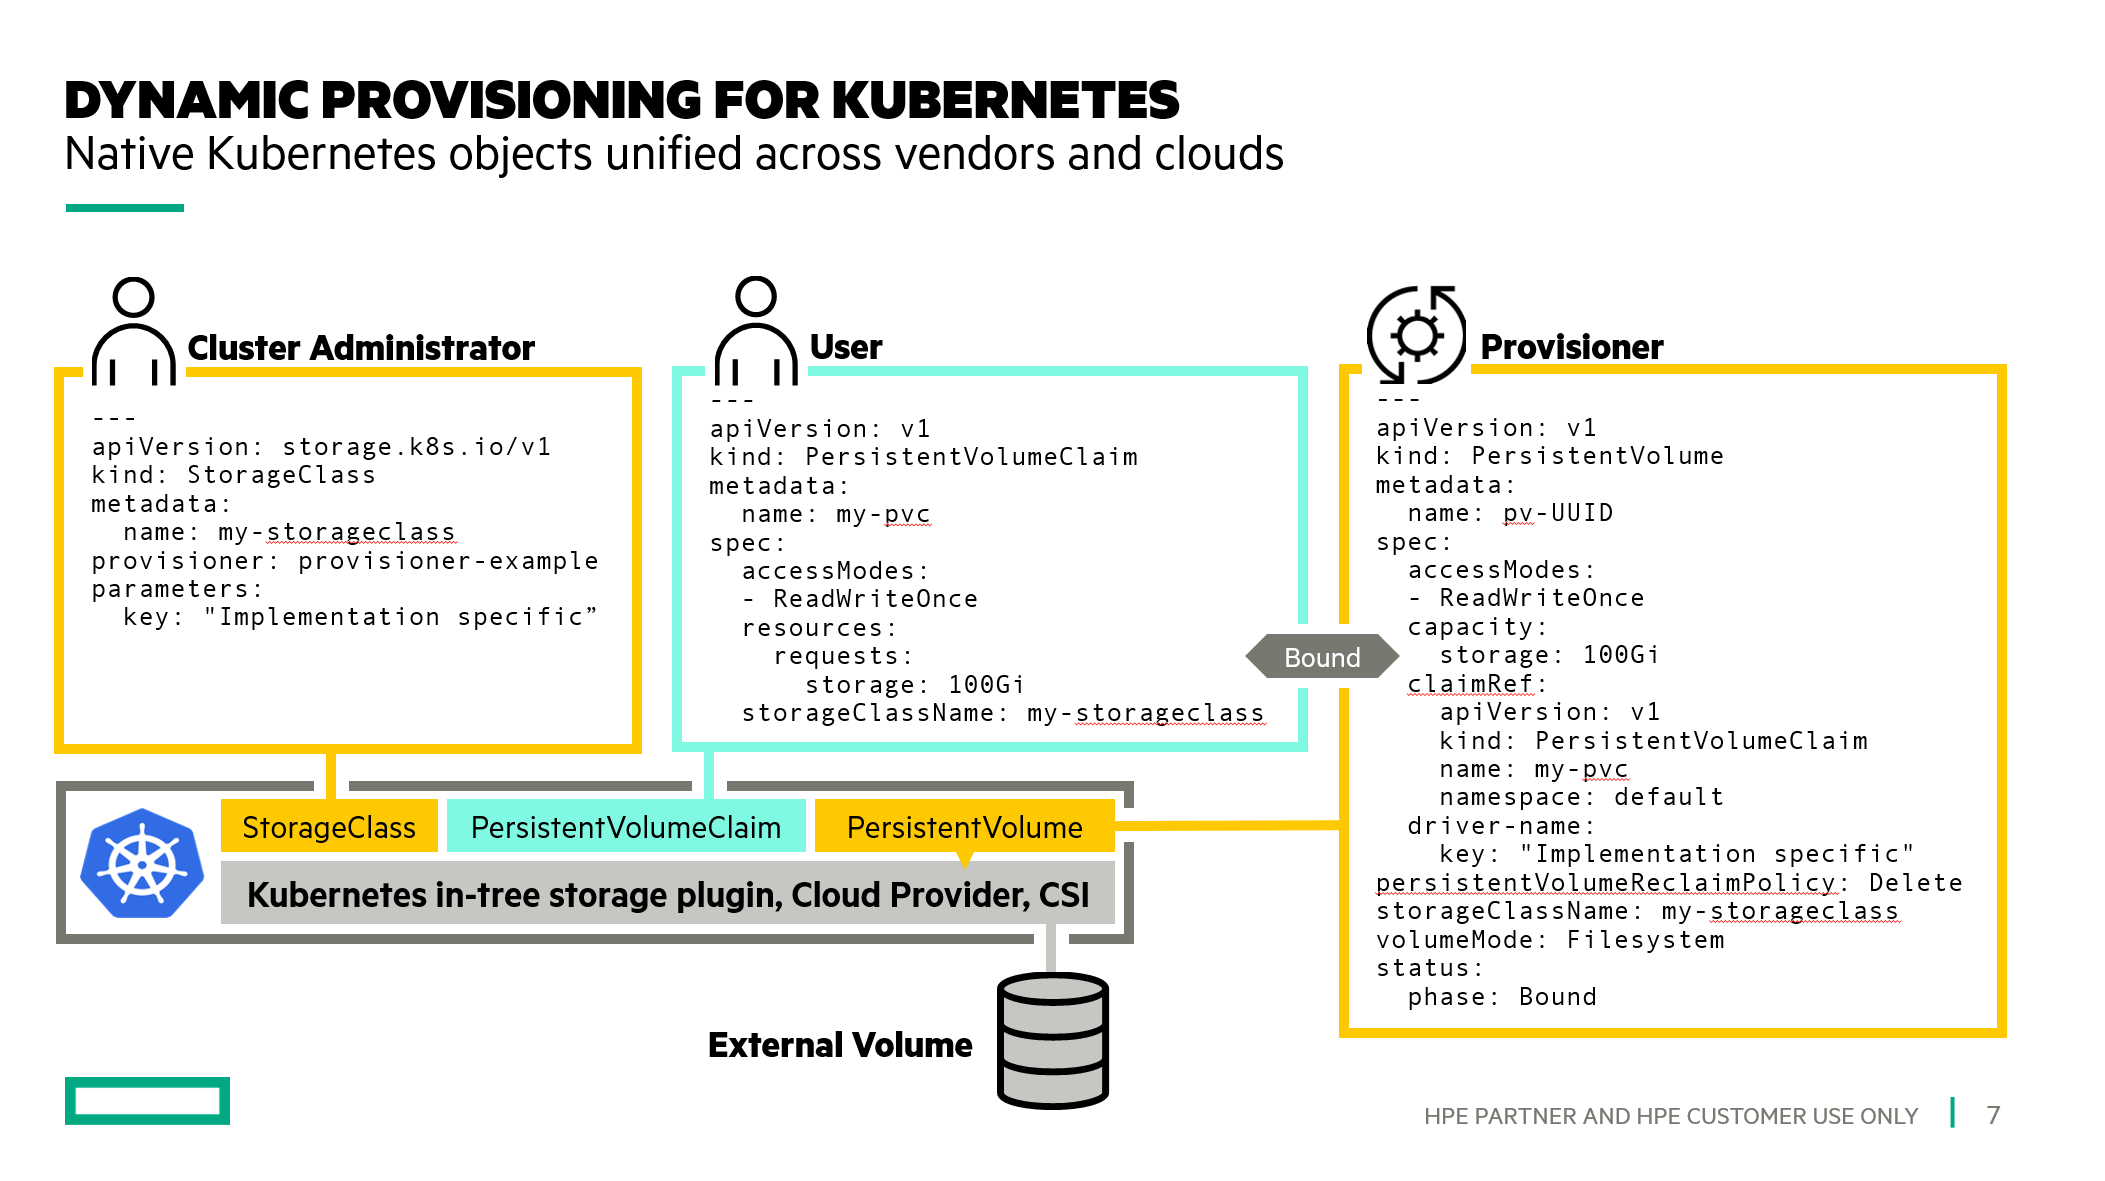

## check and set the environment

In [15]:
kubectl get nodes
echo "--- "
kubectl get sc
echo "--- "
kubectl config get-contexts

NAME                          STATUS   ROLES    AGE     VERSION
ddcp14.container.demo.local   Ready    master   2d17h   v1.17.0
ddcp15.container.demo.local   Ready    worker   2d17h   v1.17.0
--- 
NAME                PROVISIONER        RECLAIMPOLICY   VOLUMEBINDINGMODE   ALLOWVOLUMEEXPANSION   AGE
default (default)   com.mapr.csi-kdf   Delete          Immediate           false                  2d16h
hpe-standard        csi.hpe.com        Delete          Immediate           true                   2d16h
--- 
CURRENT   NAME                      CLUSTER   AUTHINFO           NAMESPACE
*         kubernetes-admin@k8s-16   k8s-16    kubernetes-admin   simple-demo


In [16]:
kubectl create ns simple-demo
kubectl config set-context --current --namespace=simple-demo
kubectl get all

namespace/simple-demo created
Context "kubernetes-admin@k8s-16" modified.
No resources found in simple-demo namespace.


## create a Storageclass


<img src="pictures/sc.png" alt="SC" width="350" height="350" style="float:left">

In [17]:
#Storageclass
cat << 'EOF' | kubectl apply -f -
---
kind: StorageClass
apiVersion: storage.k8s.io/v1
metadata:
  name: ddnimble
provisioner: csi.hpe.com
allowVolumeExpansion: true
parameters:
  accessProtocol: iscsi
  csi.storage.k8s.io/controller-expand-secret-name: nimble-secret
  csi.storage.k8s.io/controller-expand-secret-namespace: kube-system
  csi.storage.k8s.io/controller-publish-secret-name: nimble-secret
  csi.storage.k8s.io/controller-publish-secret-namespace: kube-system
  csi.storage.k8s.io/fstype: xfs
  csi.storage.k8s.io/node-publish-secret-name: nimble-secret
  csi.storage.k8s.io/node-publish-secret-namespace: kube-system
  csi.storage.k8s.io/node-stage-secret-name: nimble-secret
  csi.storage.k8s.io/node-stage-secret-namespace: kube-system
  csi.storage.k8s.io/provisioner-secret-name: nimble-secret
  csi.storage.k8s.io/provisioner-secret-namespace: kube-system
  description: Volume created by the HPE CSI Driver for Kubernetes
  folder: "simple-demo"
  reclaimPolicy: Delete
  volumeBindingMode: Immediate
  destroyOnDelete: "true"
  limitIops: "38400"
  limitMbps: "2048"
  allowOverrides: description, limitIops, limitMbps, folder, destroyOnDelete

EOF

storageclass.storage.k8s.io/ddnimble created


In [19]:
kubectl get sc
echo "---"
kubectl get sc ddnimble -o yaml

NAME                PROVISIONER        RECLAIMPOLICY   VOLUMEBINDINGMODE   ALLOWVOLUMEEXPANSION   AGE
ddnimble            csi.hpe.com        Delete          Immediate           true                   12s
default (default)   com.mapr.csi-kdf   Delete          Immediate           false                  2d17h
hpe-standard        csi.hpe.com        Delete          Immediate           true                   2d16h
---
allowVolumeExpansion: true
apiVersion: storage.k8s.io/v1
kind: StorageClass
metadata:
  annotations:
    kubectl.kubernetes.io/last-applied-configuration: |
      {"allowVolumeExpansion":true,"apiVersion":"storage.k8s.io/v1","kind":"StorageClass","metadata":{"annotations":{},"name":"ddnimble"},"parameters":{"accessProtocol":"iscsi","allowOverrides":"description, limitIops, limitMbps, folder, destroyOnDelete","csi.storage.k8s.io/controller-expand-secret-name":"nimble-secret","csi.storage.k8s.io/controller-expand-secret-namespace":"kube-system","csi.storage.k8s.io/controller-publ

## create Persistent Volume Claim (User request)


<img src="pictures/pvc.png" alt="SC" width="350" height="350" style="float:left">

In [20]:
cat << 'EOF' | kubectl apply -f -
---
kind: PersistentVolumeClaim
apiVersion: v1
metadata:
  name: ddpvc1
  annotations:
    csi.hpe.com/description: "demo the nimble plugin for K8S/Openshift/Docker/Rancher"
    csi.hpe.com/limitIOPS: "8000"
    csi.hpe.com/destroyOnDelete: "true" 
spec:
  accessModes:
    - ReadWriteOnce
  resources:
    requests:
      storage: 5Gi
  storageClassName: ddnimble
EOF

persistentvolumeclaim/ddpvc1 created


In [23]:
kubectl get pvc
echo "---"
kubectl get pv
echo "---"
kubectl describe pvc ddpvc1
echo "---"
kubectl describe pv 

NAME     STATUS   VOLUME                                     CAPACITY   ACCESS MODES   STORAGECLASS   AGE
ddpvc1   Bound    pvc-24a12f99-f4fa-445b-9b1a-624e3410fd70   5Gi        RWO            ddnimble       3m13s
---
NAME                                       CAPACITY   ACCESS MODES   RECLAIM POLICY   STATUS   CLAIM                STORAGECLASS   REASON   AGE
pvc-24a12f99-f4fa-445b-9b1a-624e3410fd70   5Gi        RWO            Delete           Bound    simple-demo/ddpvc1   ddnimble                3m13s
---
Name:          ddpvc1
Namespace:     simple-demo
StorageClass:  ddnimble
Status:        Bound
Volume:        pvc-24a12f99-f4fa-445b-9b1a-624e3410fd70
Labels:        <none>
Annotations:   csi.hpe.com/description: demo the nimble plugin for K8S/Openshift/Docker/Rancher
               csi.hpe.com/destroyOnDelete: true
               csi.hpe.com/limitIOPS: 8000
               kubectl.kubernetes.io/last-applied-configuration:
                 {"apiVersion":"v1","kind":"PersistentVolumeCla

## create Pod and attach Persistent Volume Claim

<img src="pictures/podpvc.png" alt="SC" width="350" height="350" style="float:left">

In [24]:
cat << 'EOF' | kubectl apply -f -
---
kind: Pod
apiVersion: v1
metadata:
  name: ddpod1
spec:
  containers:
  - name: nginx
    image: nginx
    volumeMounts:
    - name: export
      mountPath: /export
  restartPolicy: Always
  volumes:
  - name: export
    persistentVolumeClaim:
      claimName: ddpvc1
EOF

pod/ddpod1 created


In [26]:
kubectl get pod
kubectl describe pod ddpod1

NAME     READY   STATUS    RESTARTS   AGE
ddpod1   1/1     Running   0          15s
Name:         ddpod1
Namespace:    simple-demo
Priority:     0
Node:         ddcp15.container.demo.local/10.0.31.97
Start Time:   Thu, 30 Apr 2020 11:13:46 +0200
Labels:       <none>
Annotations:  cni.projectcalico.org/podIP: 10.192.0.180/32
              kubectl.kubernetes.io/last-applied-configuration:
                {"apiVersion":"v1","kind":"Pod","metadata":{"annotations":{},"name":"ddpod1","namespace":"simple-demo"},"spec":{"containers":[{"image":"ng...
              kubernetes.io/psp: 00-privileged
Status:       Running
IP:           10.192.0.180
IPs:
  IP:  10.192.0.180
Containers:
  nginx:
    Container ID:   docker://06f1222240f07728adf7bad964ddef73f37242f6d4227960a2b5c5a4aff21420
    Image:          nginx
    Image ID:       docker-pullable://docker.io/nginx@sha256:86ae264c3f4acb99b2dee4d0098c40cb8c46dcf9e1148f05d3a51c4df6758c12
    Port:           <none>
    Host Port:      <none>
    State:

## let´s have a look inside of the container

In [28]:
kubectl exec pod/ddpod1 ls /export

## change some files inside the container

In [29]:
kubectl exec ddpod1 -- bash -c "date > /export/ddpod1.txt" 
kubectl exec ddpod1 cat /export/ddpod1.txt

Thu Apr 30 09:15:24 UTC 2020


## destroy the pod1, create an second, with volume of first pod

<img src="pictures/delpod.png" alt="SC" width="550" height="550" style="float:left">

In [30]:
kubectl delete pod ddpod1

pod "ddpod1" deleted


In [31]:
kubectl get pod

No resources found in simple-demo namespace.


In [32]:
kubectl get pv

NAME                                       CAPACITY   ACCESS MODES   RECLAIM POLICY   STATUS   CLAIM                STORAGECLASS   REASON   AGE
pvc-24a12f99-f4fa-445b-9b1a-624e3410fd70   5Gi        RWO            Delete           Bound    simple-demo/ddpvc1   ddnimble                9m33s


## create a new Pod

In [33]:
cat << 'EOF' | kubectl apply -f -
---
kind: Pod
apiVersion: v1
metadata:
  name: ddpod2
spec:
  containers:
  - name: nginx
    image: nginx
    volumeMounts:
    - name: export
      mountPath: /export
  restartPolicy: Always
  volumes:
  - name: export
    persistentVolumeClaim:
      claimName: ddpvc1
EOF

pod/ddpod2 created


In [36]:
kubectl get all
echo "---"
kubectl describe pod ddpod2

NAME         READY   STATUS    RESTARTS   AGE
pod/ddpod2   1/1     Running   0          35s
---
Name:         ddpod2
Namespace:    simple-demo
Priority:     0
Node:         ddcp15.container.demo.local/10.0.31.97
Start Time:   Thu, 30 Apr 2020 11:16:30 +0200
Labels:       <none>
Annotations:  cni.projectcalico.org/podIP: 10.192.0.181/32
              kubectl.kubernetes.io/last-applied-configuration:
                {"apiVersion":"v1","kind":"Pod","metadata":{"annotations":{},"name":"ddpod2","namespace":"simple-demo"},"spec":{"containers":[{"image":"ng...
              kubernetes.io/psp: 00-privileged
Status:       Running
IP:           10.192.0.181
IPs:
  IP:  10.192.0.181
Containers:
  nginx:
    Container ID:   docker://ba85c625f33bea1be324dfc0ae093230b29c94443f89f6246adcafbb23e4bf49
    Image:          nginx
    Image ID:       docker-pullable://docker.io/nginx@sha256:86ae264c3f4acb99b2dee4d0098c40cb8c46dcf9e1148f05d3a51c4df6758c12
    Port:           <none>
    Host Port:      <none

In [37]:
kubectl get pods

NAME     READY   STATUS    RESTARTS   AGE
ddpod2   1/1     Running   0          46s


In [38]:
kubectl exec ddpod2 ls /export
kubectl exec ddpod2 cat /export/ddpod1.txt
kubectl exec ddpod2 -- bash -c "date > /export/ddpod2.txt" 
kubectl exec ddpod2 cat /export/ddpod2.txt

ddpod1.txt
Thu Apr 30 09:15:24 UTC 2020
Thu Apr 30 09:17:36 UTC 2020


## clone the volume

<img src="pictures/clone.png" alt="SC" width="550" height="550" style="float:left">

In [39]:
cat << 'EOF' | kubectl apply -f -
---
  kind: PersistentVolumeClaim
  apiVersion: v1
  metadata:
    name: ddpvc1-clone
  spec:
    storageClassName: ddnimble
    dataSource:
      name: ddpvc1
      kind: PersistentVolumeClaim
    accessModes:
      - ReadWriteOnce
    resources:
      requests:
        storage: 5Gi
EOF


persistentvolumeclaim/ddpvc1-clone created


In [40]:
kubectl get pvc
echo "---"
kubectl get pv
echo "---"
kubectl describe pvc ddpvc1-clone

NAME           STATUS   VOLUME                                     CAPACITY   ACCESS MODES   STORAGECLASS   AGE
ddpvc1         Bound    pvc-24a12f99-f4fa-445b-9b1a-624e3410fd70   5Gi        RWO            ddnimble       12m
ddpvc1-clone   Bound    pvc-f142f4d5-1553-488d-9e0c-40936a338f68   5Gi        RWO            ddnimble       5s
---
NAME                                       CAPACITY   ACCESS MODES   RECLAIM POLICY   STATUS   CLAIM                      STORAGECLASS   REASON   AGE
pvc-24a12f99-f4fa-445b-9b1a-624e3410fd70   5Gi        RWO            Delete           Bound    simple-demo/ddpvc1         ddnimble                12m
pvc-f142f4d5-1553-488d-9e0c-40936a338f68   5Gi        RWO            Delete           Bound    simple-demo/ddpvc1-clone   ddnimble                5s
---
Name:          ddpvc1-clone
Namespace:     simple-demo
StorageClass:  ddnimble
Status:        Bound
Volume:        pvc-f142f4d5-1553-488d-9e0c-40936a338f68
Labels:        <none>
Annotations:   kubectl.kuberne

In [41]:
kubectl apply -f - << EOF
---
kind: Pod
apiVersion: v1
metadata:
  name: ddpod3
spec:
  containers:
  - name: nginx
    image: nginx
    volumeMounts:
    - name: export
      mountPath: /export
  restartPolicy: Always
  volumes:
  - name: export
    persistentVolumeClaim:
      claimName: ddpvc1-clone
EOF

pod/ddpod3 created


In [43]:
kubectl get pod
echo "---"
kubectl get pvc
echo "---"
kubectl describe pod ddpod3

NAME     READY   STATUS    RESTARTS   AGE
ddpod2   1/1     Running   0          3m53s
ddpod3   1/1     Running   0          21s
---
NAME           STATUS   VOLUME                                     CAPACITY   ACCESS MODES   STORAGECLASS   AGE
ddpvc1         Bound    pvc-24a12f99-f4fa-445b-9b1a-624e3410fd70   5Gi        RWO            ddnimble       13m
ddpvc1-clone   Bound    pvc-f142f4d5-1553-488d-9e0c-40936a338f68   5Gi        RWO            ddnimble       96s
---
Name:         ddpod3
Namespace:    simple-demo
Priority:     0
Node:         ddcp15.container.demo.local/10.0.31.97
Start Time:   Thu, 30 Apr 2020 11:20:02 +0200
Labels:       <none>
Annotations:  cni.projectcalico.org/podIP: 10.192.0.182/32
              kubectl.kubernetes.io/last-applied-configuration:
                {"apiVersion":"v1","kind":"Pod","metadata":{"annotations":{},"name":"ddpod3","namespace":"simple-demo"},"spec":{"containers":[{"image":"ng...
              kubernetes.io/psp: 00-privileged
Status:       Run

In [44]:
kubectl exec ddpod3  ls /export
kubectl exec ddpod3 cat /export/ddpod2.txt

ddpod1.txt
ddpod2.txt
Thu Apr 30 09:17:36 UTC 2020


## snapshot the volume

https://scod.hpedev.io/csi_driver/using.html#enabling_csi_snapshots

### Deploy the necessary resources

As per the Kubernetes Special Interest Group (SIG) Storage, the snapshot controllers, custom resource definitions and RBAC resources should be deployed on the cluster by the vendor of the Kubernetes distribution, not the CSI driver vendor. These resources are not deployed on upstream Kubernetes 1.17.4, which is being used in this tutorial. Now, let’s deploy the necessary resources.

**IMPORTANT:before, let´s check if we do have the right api version is already enabled, as in v1.17 we need v1beta1 as the endpoint for the snapshot.**

In [45]:
kubectl api-versions

admissionregistration.k8s.io/v1
admissionregistration.k8s.io/v1beta1
apiextensions.k8s.io/v1
apiextensions.k8s.io/v1beta1
apiregistration.k8s.io/v1
apiregistration.k8s.io/v1beta1
apps/v1
authentication.k8s.io/v1
authentication.k8s.io/v1beta1
authorization.k8s.io/v1
authorization.k8s.io/v1beta1
autoscaling/v1
autoscaling/v2beta1
autoscaling/v2beta2
batch/v1
batch/v1beta1
certificates.k8s.io/v1beta1
coordination.k8s.io/v1
coordination.k8s.io/v1beta1
crd.projectcalico.org/v1
discovery.k8s.io/v1beta1
events.k8s.io/v1beta1
extensions/v1beta1
hpecp.hpe.com/v1
kubedirector.hpe.com/v1beta1
metrics.k8s.io/v1beta1
networking.k8s.io/v1
networking.k8s.io/v1beta1
node.k8s.io/v1beta1
policy/v1beta1
rbac.authorization.k8s.io/v1
rbac.authorization.k8s.io/v1beta1
scheduling.k8s.io/v1
scheduling.k8s.io/v1beta1
settings.k8s.io/v1alpha1
snapshot.storage.k8s.io/v1beta1
storage.hpe.com/v1
storage.k8s.io/v1
storage.k8s.io/v1beta1
v1


if required you can exchange the create command to delete, to get the newest crd version.

In [46]:
#some resources may exist already
kubectl apply -f https://raw.githubusercontent.com/kubernetes-csi/external-snapshotter/master/config/crd/snapshot.storage.k8s.io_volumesnapshotclasses.yaml
kubectl apply -f https://raw.githubusercontent.com/kubernetes-csi/external-snapshotter/master/config/crd/snapshot.storage.k8s.io_volumesnapshotcontents.yaml
kubectl apply -f https://raw.githubusercontent.com/kubernetes-csi/external-snapshotter/master/config/crd/snapshot.storage.k8s.io_volumesnapshots.yaml
kubectl apply -f https://raw.githubusercontent.com/kubernetes-csi/external-snapshotter/master/deploy/kubernetes/snapshot-controller/rbac-snapshot-controller.yaml
kubectl apply -f https://raw.githubusercontent.com/kubernetes-csi/external-snapshotter/master/deploy/kubernetes/snapshot-controller/setup-snapshot-controller.yaml

customresourcedefinition.apiextensions.k8s.io/volumesnapshotclasses.snapshot.storage.k8s.io configured
customresourcedefinition.apiextensions.k8s.io/volumesnapshotcontents.snapshot.storage.k8s.io configured
customresourcedefinition.apiextensions.k8s.io/volumesnapshots.snapshot.storage.k8s.io configured
serviceaccount/snapshot-controller created
clusterrole.rbac.authorization.k8s.io/snapshot-controller-runner unchanged
clusterrolebinding.rbac.authorization.k8s.io/snapshot-controller-role configured
role.rbac.authorization.k8s.io/snapshot-controller-leaderelection unchanged
rolebinding.rbac.authorization.k8s.io/snapshot-controller-leaderelection unchanged
statefulset.apps/snapshot-controller created


**IMPORTANT**

``as we are depolying not in the default namespace, we had to tweak the RBAC Clusterrolebinding for the serviceAccount (snapshot-controller).``

In [48]:
kubectl patch ClusterRolebinding snapshot-controller-role -p '{"subjects":[{"kind":"ServiceAccount","name":"snapshot-controller","namespace":"simple-demo"}]}'

clusterrolebinding.rbac.authorization.k8s.io/snapshot-controller-role patched


In [49]:
kubectl get ClusterRoleBinding snapshot-controller-role -o json  # namespace is patched from default to simple-demo in this case.

{
    "apiVersion": "rbac.authorization.k8s.io/v1",
    "kind": "ClusterRoleBinding",
    "metadata": {
        "annotations": {
            "kubectl.kubernetes.io/last-applied-configuration": "{\"apiVersion\":\"rbac.authorization.k8s.io/v1\",\"kind\":\"ClusterRoleBinding\",\"metadata\":{\"annotations\":{},\"name\":\"snapshot-controller-role\"},\"roleRef\":{\"apiGroup\":\"rbac.authorization.k8s.io\",\"kind\":\"ClusterRole\",\"name\":\"snapshot-controller-runner\"},\"subjects\":[{\"kind\":\"ServiceAccount\",\"name\":\"snapshot-controller\",\"namespace\":\"default\"}]}\n"
        },
        "creationTimestamp": "2020-04-27T16:40:58Z",
        "name": "snapshot-controller-role",
        "resourceVersion": "514147",
        "selfLink": "/apis/rbac.authorization.k8s.io/v1/clusterrolebindings/snapshot-controller-role",
        "uid": "7d577154-0184-4820-b2e1-35b3bb5b6918"
    },
    "roleRef": {
        "apiGroup": "rbac.authorization.k8s.io",
        "kind": "ClusterRole",
        "name": "

### create the VolumeSnapshotClass

<img src="pictures/snapshoting.png" alt="SC" width="550" height="550" style="float:left">

For each CSI driver that supports snapshots, at least one VolumeSnapshotClass object needs to be created. There’s only one backend that supports snapshots on this cluster and the VolumeSnapshotClass is therefore marked as default, which makes it easy for users to not care about implementation details.

In [51]:
kubectl apply -f - << EOF
---
apiVersion: snapshot.storage.k8s.io/v1beta1 
kind: VolumeSnapshotClass
metadata:
  name: hpe-snapshot
  annotations:
    snapshot.storage.kubernetes.io/is-default-class: "true"
driver: csi.hpe.com
deletionPolicy: Delete
parameters:
  description: "Snapshot created by the HPE CSI Driver"
  csi.storage.k8s.io/snapshotter-secret-name: nimble-secret
  csi.storage.k8s.io/snapshotter-secret-namespace: kube-system
EOF

volumesnapshotclass.snapshot.storage.k8s.io/hpe-snapshot created


In [53]:
kubectl get VolumeSnapshotClass
kubectl get VolumeSnapshotClass -o yaml

NAME           DRIVER        DELETIONPOLICY   AGE
hpe-snapshot   csi.hpe.com   Delete           18s
apiVersion: v1
items:
- apiVersion: snapshot.storage.k8s.io/v1beta1
  deletionPolicy: Delete
  driver: csi.hpe.com
  kind: VolumeSnapshotClass
  metadata:
    annotations:
      kubectl.kubernetes.io/last-applied-configuration: |
        {"apiVersion":"snapshot.storage.k8s.io/v1beta1","deletionPolicy":"Delete","driver":"csi.hpe.com","kind":"VolumeSnapshotClass","metadata":{"annotations":{"snapshot.storage.kubernetes.io/is-default-class":"true"},"name":"hpe-snapshot"},"parameters":{"csi.storage.k8s.io/snapshotter-secret-name":"nimble-secret","csi.storage.k8s.io/snapshotter-secret-namespace":"kube-system","description":"Snapshot created by the HPE CSI Driver"}}
      snapshot.storage.kubernetes.io/is-default-class: "true"
    creationTimestamp: "2020-04-30T09:23:51Z"
    generation: 1
    name: hpe-snapshot
    resourceVersion: "514322"
    selfLink: /apis/snapshot.storage.k8s.io/v1beta1/v

### create Snapshot (User request)

<img src="pictures/snapshot.png" alt="SC" width="950" height="950" style="float:left">

In [54]:
cat << 'EOF' | kubectl apply -f -
---
apiVersion: snapshot.storage.k8s.io/v1beta1
kind: VolumeSnapshot
metadata:
  name: ddpvc-clone-snap1
spec:
  source:
    persistentVolumeClaimName: "ddpvc1-clone"
EOF

volumesnapshot.snapshot.storage.k8s.io/ddpvc-clone-snap1 created


In [56]:
kubectl get volumesnapshot

NAME                READYTOUSE   SOURCEPVC      SOURCESNAPSHOTCONTENT   RESTORESIZE   SNAPSHOTCLASS   SNAPSHOTCONTENT                                    CREATIONTIME   AGE
ddpvc-clone-snap1   true         ddpvc1-clone                           5Gi           hpe-snapshot    snapcontent-7f37aa2c-1624-4cc0-b6a0-409f6794e7ef   32s            31s


In [ ]:
kubectl delete volumesnapshot ddpvc-clone-snap1

## expand an Volume

<img src="pictures/expand.png" alt="SC" width="350" height="350" style="float:left">

To perform expansion operations on Kubernetes 1.14+, you must enhance your StorageClass with some additional attributes.

``kubectl patch sc ddnimble -p '{ "allowVolumeExpansion": true }'``

In [59]:
kubectl describe sc ddnimble 

Name:            ddnimble
IsDefaultClass:  No
Annotations:     kubectl.kubernetes.io/last-applied-configuration={"allowVolumeExpansion":true,"apiVersion":"storage.k8s.io/v1","kind":"StorageClass","metadata":{"annotations":{},"name":"ddnimble"},"parameters":{"accessProtocol":"iscsi","allowOverrides":"description, limitIops, limitMbps, folder, destroyOnDelete","csi.storage.k8s.io/controller-expand-secret-name":"nimble-secret","csi.storage.k8s.io/controller-expand-secret-namespace":"kube-system","csi.storage.k8s.io/controller-publish-secret-name":"nimble-secret","csi.storage.k8s.io/controller-publish-secret-namespace":"kube-system","csi.storage.k8s.io/fstype":"xfs","csi.storage.k8s.io/node-publish-secret-name":"nimble-secret","csi.storage.k8s.io/node-publish-secret-namespace":"kube-system","csi.storage.k8s.io/node-stage-secret-name":"nimble-secret","csi.storage.k8s.io/node-stage-secret-namespace":"kube-system","csi.storage.k8s.io/provisioner-secret-name":"nimble-secret","csi.storage.k8s.i

In [60]:
kubectl exec -it ddpod2 -- bash -c 'df -h /export'

Filesystem          Size  Used Avail Use% Mounted on
/dev/mapper/mpatht  5.0G   33M  5.0G   1% /export


In [61]:
cat << 'EOF' | kubectl apply -f -
---
apiVersion: v1
kind: PersistentVolumeClaim
metadata:
  name: ddpvc1
  annotations:
    csi.hpe.com/description: "demo the nimble plugin for K8S/Openshift/Docker/Rancher"
    csi.hpe.com/limitIOPS: "8000"
    csi.hpe.com/destroyOnDelete: "true" 
spec:
  accessModes:
  - ReadWriteOnce
  resources:
    requests:
      storage: 10Gi
  storageClassName: ddnimble  
EOF


persistentvolumeclaim/ddpvc1 configured


In [72]:
# IMPORTANT: it may take a while until the new size is applied (est.: 1 Minute)
kubectl exec -it ddpod2 -- bash -c 'df -h /export'

Filesystem          Size  Used Avail Use% Mounted on
/dev/mapper/mpatht   10G   33M   10G   1% /export


In [ ]:
kubectl get pv,pvc

## import an pre-existing Volume 
(Volume exists on Nimble, but unknown to k8s)

In [73]:
cat << 'EOF' | kubectl apply -f -
apiVersion: storage.k8s.io/v1
kind: StorageClass
metadata:
  name: import-nimble-volume
provisioner: csi.hpe.com
parameters:
  description: "Volume provisioned by the HPE CSI Driver"
  accessProtocol: "iscsi"
  csi.storage.k8s.io/fstype: xfs
  csi.storage.k8s.io/provisioner-secret-name: nimble-secret
  csi.storage.k8s.io/provisioner-secret-namespace: kube-system
  csi.storage.k8s.io/controller-publish-secret-name: nimble-secret
  csi.storage.k8s.io/controller-publish-secret-namespace: kube-system
  csi.storage.k8s.io/node-stage-secret-name: nimble-secret
  csi.storage.k8s.io/node-stage-secret-namespace: kube-system
  csi.storage.k8s.io/node-publish-secret-name: nimble-secret
  csi.storage.k8s.io/node-publish-secret-namespace: kube-system
  csi.storage.k8s.io/controller-expand-secret-name: nimble-secret
  csi.storage.k8s.io/controller-expand-secret-namespace: kube-system
  destroyOnDelete: "true"
  # importVolAsClone: "VolumetoImport"
  # importVolumeName: "VolumetoImport"
# Extras...|
  allowOverrides: limitIops, limitMbps, folder, importVolAsClone, importVolumeName
#allowVolumeExpansion: True
EOF

storageclass.storage.k8s.io/import-nimble-volume created


In [74]:
kubectl get sc

NAME                   PROVISIONER        RECLAIMPOLICY   VOLUMEBINDINGMODE   ALLOWVOLUMEEXPANSION   AGE
ddnimble               csi.hpe.com        Delete          Immediate           true                   26m
default (default)      com.mapr.csi-kdf   Delete          Immediate           false                  2d17h
hpe-standard           csi.hpe.com        Delete          Immediate           true                   2d16h
import-nimble-volume   csi.hpe.com        Delete          Immediate           false                  8s


important:
**allowOverrides: limitIops, limitMbps, folder, importVolAsClone, importVolumeName**

``Import note: if you use the importVolumeName, the name of the volume will be renamed
form myDatabase to pvc-<uid>``

``myimportedvolume   Bound    pvc-66b42c29-dcdc-413e-8a28-c147be4aa1d9   5Gi        RWO            import-nimble-volume   6s``

In [75]:
cat << 'EOF' | kubectl apply -f -
---
kind: PersistentVolumeClaim
apiVersion: v1
metadata:
  name: myimportedvolume
  annotations:  
    csi.hpe.com/importVolAsClone: "myDatabase"
    csi.hpe.com/description: "myDatabase Demo Volume"
    # csi.hpe.com/importVolumeName: "myDatabase"
    csi.hpe.com/folder: "simple-demo"
spec:
  accessModes:
    - ReadWriteOnce
  resources:
    requests:
      storage: 5Gi
  storageClassName: import-nimble-volume
EOF

persistentvolumeclaim/myimportedvolume created


In [76]:
kubectl get pvc 

NAME               STATUS   VOLUME                                     CAPACITY   ACCESS MODES   STORAGECLASS           AGE
ddpvc1             Bound    pvc-24a12f99-f4fa-445b-9b1a-624e3410fd70   10Gi       RWO            ddnimble               25m
ddpvc1-clone       Bound    pvc-f142f4d5-1553-488d-9e0c-40936a338f68   5Gi        RWO            ddnimble               13m
myimportedvolume   Bound    pvc-bef441a7-9a56-4d73-b30f-d2508408ea80   5Gi        RWO            import-nimble-volume   3s


In [77]:
kubectl create -f - << EOF
---
kind: Pod
apiVersion: v1
metadata:
  name: ddpod4
spec:
  containers:
  - name: nginx
    image: nginx
    volumeMounts:
    - name: export
      mountPath: /export
  restartPolicy: Always
  volumes:
  - name: export
    persistentVolumeClaim:
      claimName: myimportedvolume
EOF

pod/ddpod4 created


In [78]:
kubectl get pods

NAME                    READY   STATUS    RESTARTS   AGE
ddpod2                  1/1     Running   0          16m
ddpod3                  1/1     Running   0          13m
ddpod4                  1/1     Running   0          47s
snapshot-controller-0   1/1     Running   0          11m


In [79]:
kubectl exec -it ddpod4 ls /export

database-volume   database-volume3  database-volume5
database-volume2  database-volume4


## cleanup

In [ ]:
kubectl delete sc ddnimble
kubectl delete sc import-nimble-volume
kubectl delete volumesnapshotclass hpe-snapshot
kubectl delete volumesnapshot ddpvc-clone-snap1
kubectl delete ns simple-demo
#kubectl delete pv $(kubectl get pv| grep -i simple-demo| awk ' { print $1 }')

storageclass.storage.k8s.io "ddnimble" deleted
storageclass.storage.k8s.io "import-nimble-volume" deleted
volumesnapshotclass.snapshot.storage.k8s.io "hpe-snapshot" deleted
volumesnapshot.snapshot.storage.k8s.io "ddpvc-clone-snap1" deleted
